# 5.9 (b) p.346
## Keras スタイルのコーディング

<a href="../html/tf2_book4_ch05_02c.html">5.3章 (c)</a> の例を題材とする。

### 5.2 (b)のコードを転載する
<font color="red">[自分へのメモ]</font> t_train, t_test は one hot vector 化して、loss='categorical_crossentropy' を使うように変更することに注意。

In [1]:
# 5-02-20 CIFAR-10 データセットの読み込み
# p.312

from tensorflow.keras import datasets

(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
# 5-02-21 CNN モデルの構築
# p.312
# [自分へのメモ] 関数呼び出しでモデルを作るように変更した。これで複数のモデルを作成して実験できる。

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

def CNN(input_dim, output_dim):
    weight_decay = 1e-4
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=input_dim,padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(output_dim,activation='softmax'))
    return model

In [7]:
learning_rate = 0.1

model2 = CNN(x_train.shape[1:], 10)
model2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=learning_rate),
    metrics=['accuracy']
    )

In [6]:
t_train_cat = tf.keras.utils.to_categorical(t_train, 10)
t_test_cat = tf.keras.utils.to_categorical(t_test, 10)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=64

datagen2 = ImageDataGenerator(
    rescale=1.0/255.0, ### [0,1]に正規化
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
    )
datagen2.fit(x_train)
training_generator2 = datagen2.flow(
    x_train,   ### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

validation_generator2 = datagen2.flow(
    x_train,   #### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )

## Kerasで学習の早期終了を指定する

In [10]:
# 5-09-4 Kerasスタイルで早期学習終了に対応する
# p.347
# [自分へのメモ] loss=categorical_crossentropy に変更している

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
    )

epochs = 200

history2 = model2.fit(
    training_generator2,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator2,
    callbacks=[early_stopping]    ### !!! Early Stopping
    )

Epoch 1/200
625/625 [==============================] - 24s 38ms/step - loss: 2.0003 - accuracy: 0.2819 - val_loss: 1.7963 - val_accuracy: 0.3531
Epoch 2/200
625/625 [==============================] - 24s 38ms/step - loss: 1.5960 - accuracy: 0.4324 - val_loss: 1.4541 - val_accuracy: 0.4825
Epoch 3/200
625/625 [==============================] - 24s 38ms/step - loss: 1.4412 - accuracy: 0.4873 - val_loss: 1.3147 - val_accuracy: 0.5436
Epoch 4/200
625/625 [==============================] - 24s 38ms/step - loss: 1.3232 - accuracy: 0.5348 - val_loss: 1.2147 - val_accuracy: 0.5782
Epoch 5/200
625/625 [==============================] - 24s 38ms/step - loss: 1.2349 - accuracy: 0.5706 - val_loss: 1.1549 - val_accuracy: 0.5947
Epoch 6/200
625/625 [==============================] - 23s 37ms/step - loss: 1.1705 - accuracy: 0.5985 - val_loss: 1.1265 - val_accuracy: 0.6111
Epoch 7/200
625/625 [==============================] - 24s 38ms/step - loss: 1.1107 - accuracy: 0.6180 - val_loss: 1.0419 - val_ac

In [11]:
# 5-02-23 損失と精度の推移をグラフにする
# p.317
# [自分へのメモ] 独自のコードで書き直した

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
    
    ax[0].plot(history.history['accuracy'], "-", label="accuracy",c="blue")
    ax[0].plot(history.history['val_accuracy'], "-", label="val_accuracy",c="green")
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc="lower right")
    
    ax[1].plot(history.history['loss'], "-", label="loss", c="blue")
    ax[1].plot(history.history['val_loss'], "-", label="val_loss", c="green")
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc="upper left")

    plt.subplots_adjust(wspace=0.1)
    plt.show()

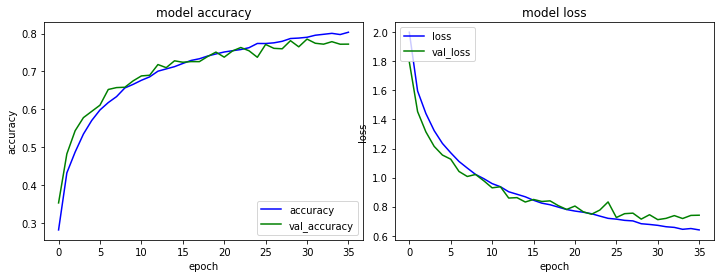

In [12]:
plot_history(history2)

In [14]:
# 学習結果を評価する
# [自分へのメモ]　ImageDataGenerator(rescale=1.0/255)しているので、x_testは[0,255]から[0, 1]に変換する必要がある
test_loss, test_acc = model2.evaluate(x_test.astype('float32')/255, t_test_cat, verbose=0)
print(f'test_loss: {test_loss:.4f}  test_acc: {test_acc:.4f}')

test_loss: 0.7124  test_acc: 0.7805
